<a href="https://colab.research.google.com/github/rodrigo-cl-porto/Image-Recommendation-System/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando as bibliotecas

In [2]:
import os
import numpy as np
import pandas as pd
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.preprocessing import image as keras_image
from keras.models import Model
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import gc

## Preparando para importar o dataset do Kaggle

In [4]:
#hide
%%writefile kaggle.json
{"username":"<your kaggle username>","key":"<your kaggle api key>"}

Writing kaggle.json


In [6]:
#hide
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


In [9]:
#hide-output
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/images/58150.jpg  
  inflating: myntradata

In [10]:
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [04:11<00:00, 176.44it/s]

Moved 44441 images.


## Preparando utilitários

In [5]:
IMAGE_DIR = '/content/Fashion_data/categories'
EMBEDDING_DIM = 1280  # para EfficientNetB0
BATCH_SIZE = 64
TARGET_SIZE = (224, 224)

def build_feature_extractor():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
    return Model(inputs=base_model.input, outputs=base_model.output)

def get_image_paths(image_dir):
    paths, labels = [], []
    for class_dir in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_dir)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(class_path, fname))
                labels.append(class_dir)
    return paths, labels

def load_batch(img_paths):
    batch, valid_paths = [], []
    for path in img_paths:
        try:
            img = keras_image.load_img(path, target_size=TARGET_SIZE)
            img_array = keras_image.img_to_array(img)
            batch.append(img_array)
            valid_paths.append(path)
        except Exception as e:
            print(f"Erro ao carregar {path}: {e}")
            continue
    return np.array(batch), valid_paths

def extract_and_save_embeddings(model, image_paths, batch_size=BATCH_SIZE):
    all_embeddings = []
    all_valid_paths = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        batch_imgs, valid_paths = load_batch(batch_paths)

        if len(batch_imgs) == 0:
            continue

        batch_imgs = preprocess_input(batch_imgs)
        embeddings = model.predict(batch_imgs, verbose=0)

        all_embeddings.append(embeddings)
        all_valid_paths.extend(valid_paths)

        del batch_imgs
        gc.collect()

    all_embeddings = np.concatenate(all_embeddings, axis=0)
    return all_embeddings, all_valid_paths


## Extrair embeddings e salvar para reuso

In [7]:
print("🔄 Coletando caminhos das imagens...")
paths, labels = get_image_paths(IMAGE_DIR)

print(f"🖼️ Total de imagens encontradas: {len(paths)}")

print("📐 Extraindo embeddings em lotes...")
model = build_feature_extractor()
embeddings, valid_paths = extract_and_save_embeddings(model, paths)

# Salvando os embeddings e os caminhos
np.save('/content/embeddings.npy', embeddings)
np.save('/content/paths.npy', np.array(valid_paths))

🔄 Coletando caminhos das imagens...
🖼️ Total de imagens encontradas: 44441
📐 Extraindo embeddings em lotes...


100%|██████████| 695/695 [1:15:29<00:00,  6.52s/it]


## Fazer recomendações por similaridade visual

🔍 Treinando modelo de KNN...
🖼️ Produto consultado: /content/Fashion_data/categories/Accessories/59292.jpg


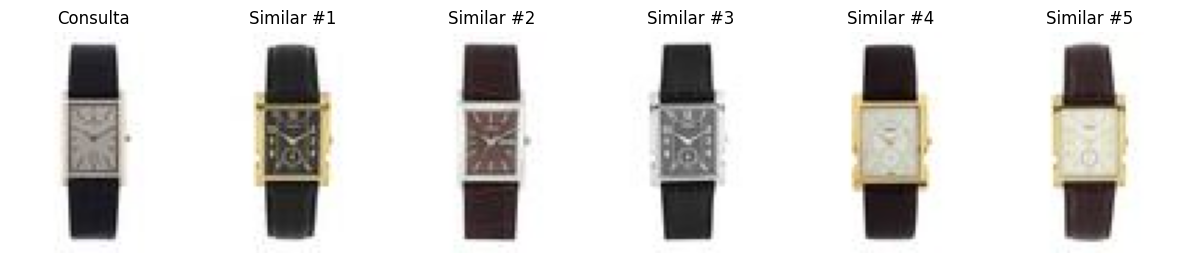

In [8]:
# (Recarregue se quiser reutilizar depois sem reprocessar)
embeddings = np.load('/content/embeddings.npy')
valid_paths = np.load('/content/paths.npy')

print("🔍 Treinando modelo de KNN...")
knn = NearestNeighbors(n_neighbors=6, metric='cosine')
knn.fit(embeddings)

consulta_idx = np.random.randint(0, len(valid_paths))
distances, indices = knn.kneighbors([embeddings[consulta_idx]])

def show_similar_images(query_path, paths, indices, n=5):
    query_img = cv2.imread(query_path)[:, :, ::-1]
    plt.figure(figsize=(15, 3))
    plt.subplot(1, n+1, 1)
    plt.imshow(query_img)
    plt.title("Consulta")
    plt.axis('off')

    for i in range(n):
        sim_img = cv2.imread(paths[indices[i]])[:, :, ::-1]
        plt.subplot(1, n+1, i+2)
        plt.imshow(sim_img)
        plt.title(f"Similar #{i+1}")
        plt.axis('off')
    plt.show()

print(f"🖼️ Produto consultado: {valid_paths[consulta_idx]}")
show_similar_images(valid_paths[consulta_idx], valid_paths, indices[0][1:])